# CRW simulator, one patch-size, many walks

In [ ]:
# Dave Hunt
# University of Washington
# March 27, 2021

# This notebook plots patch encounter data generated from sets of correlated random walks (~100 walks x 10,000 steps) 
# at varying concentrations, utilizing the CRWutils.py module

#  CRW/ 
#    │
#    ├──src/
#    │   └──CRWutils.py
#    │
#    ├──notebooks/
#    │   └── CRW simulator.ipynb
#    │
#    ├──data/
#    │   └── all csv results *.csv from random walks
#    │
#    └──graphs/
#        └── all graphs created from csv data
#
# Copyright (c) 2021, David Hunt
# All rights reserved.

# This source code is licensed under the BSD-style license found in the
# LICENSE file in the root directory of this source tree. 

This notebook utilizes the CRWutils.py library of correlated random walk functionst to simulate the encounters of a foraging hunter-gatherer at varying levels of directional persistence in an otherwise neutral landscape.


The program completes a number of independent walks (total = num_of_walks), each comprised of num_of_steps steps.
At each step, a step direction (one of 8 grid directions) is selected, influenced by the probability distribution in use (prob_list) and the walk progresses.  If a lithic source is detected at the new location, its details are recorded and the walk is terminated. Each new walk begins from the same location in the center of the grid (central place foraging).

In my tests, for each patch-size (i.e., 1x1, 2x2 ... 9x9), I ran 100 walks of 10,000 steps.  This is quite time-consuming,
taking more than 24 hours per patch-size on my personal computer running an AMD Ryzen 7 3800X 8-Core processor with 32 GB of RAM. For this reason, it may be useful to run in batches using the patch_size_start and patch_size_end variables to just test
one or two patch sizes at a time and then consolidate the results from walk_results.

In [45]:
%config IPCompleter.greedy=True

In [46]:
%cd d:\\dev\Python\CRW\src

d:\dev\Python\CRW\src


In [47]:
# included Python libraries
import numpy as np
import pandas as pd
import CRWutils as crw
from datetime import datetime

In [48]:
%cd d:\\dev\Python\CRW

d:\dev\Python\CRW


In [49]:
# Set the specifics the walks, patch-sizes to test, and spacing (offset) here:
num_of_walks = 50
num_of_steps = 1000
patch_size_start = 8      # the first patch size to test, integer, for example, for a 3x3 patch, set to 3
patch_size_end = 9        # the last patch size to test, not inclusive
offset_step =20           # the offset to use.  The first patch will be placed one cell away (closest corner of the patch) from Home
                          #    subsequent patches will be moved x = x - offset and y = y - offset away from Home, towards (0,0)
                          #    Setting offset to 1 provides the largest sample set
        
rho = 0.5                 # the level of directional persistence is set by the concentration parameter, rho, using a value
                          # between 0 and 1.  Zero implies no persistent (replicates a simple random walk) while 1 forces
                          # absolute directional persistence (a straight line).

In [50]:
# initialization
crw.reset_variables()                               # reset needs to occur before each set of walks
crw.prob_list = crw.get_prob_list(rho)              # generates the directional persistence probability distribution
offset_X = 0                                        # the starting offset of the patch (from Home)
offset_Y = 0
walk_results = []                                   # all walk results are saved here

In [51]:
crw.prob_list                                       # demonstrates the distribution of persistence probablities
                                                    # across the 8 nearest neighbors surrounding a cell in a grid

(0.342512168807213,
 0.181448540128761,
 0.07753802880615401,
 0.048682935565697916,
 0.04214882219156113,
 0.048682935565697916,
 0.07753802880615401,
 0.181448540128761)

In [52]:
crw.initialize_grid(200,200)                        # creates a 200x200 cell grid

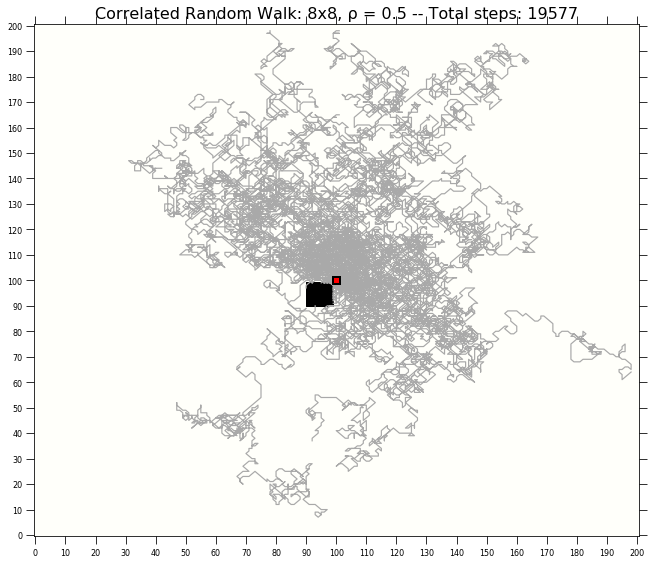

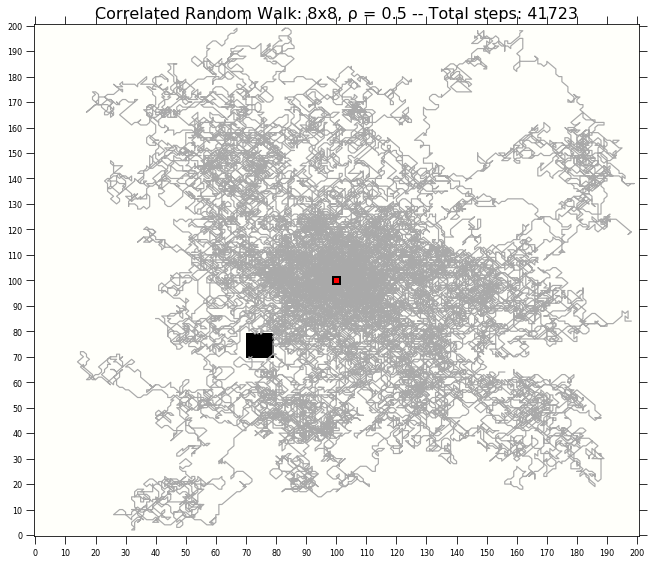

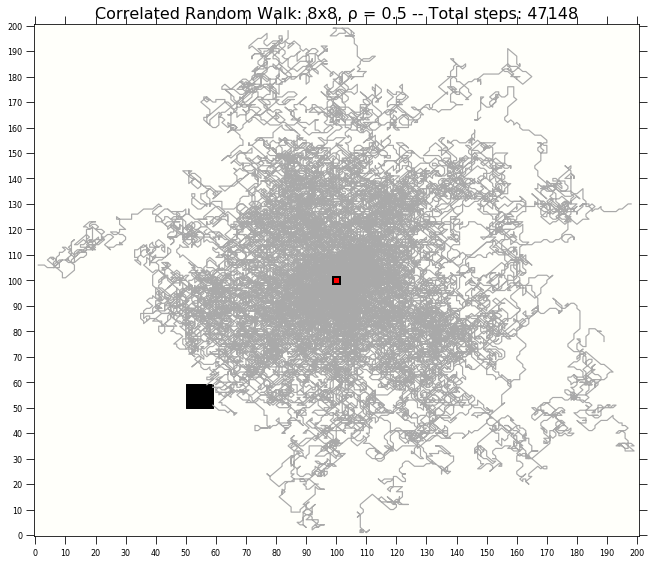

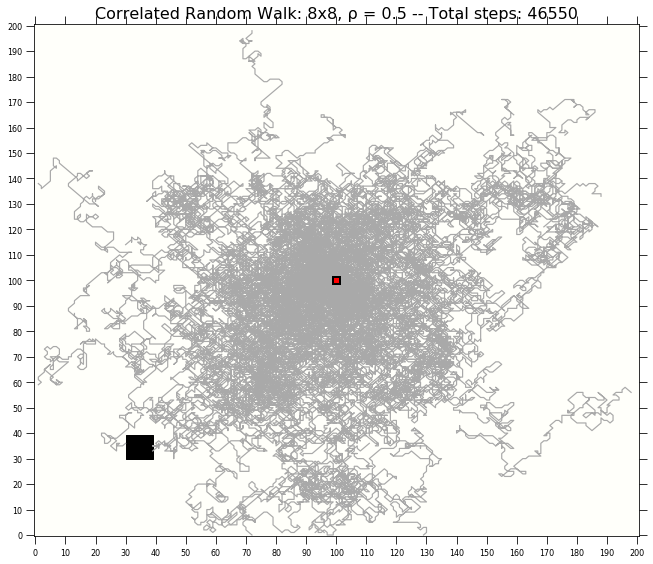

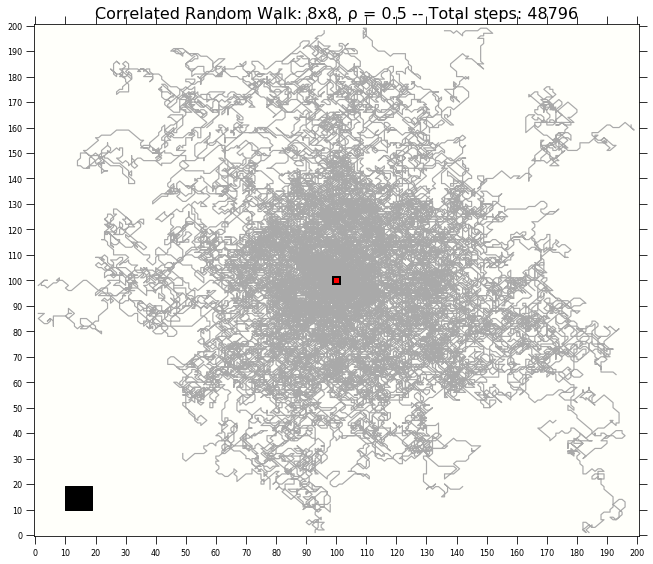

In [53]:
for p in range(patch_size_start, patch_size_end):  # repeat for a range of patch sizes
    patch_size = p
    offset_X = patch_size + 1                      # initially place the patch one-cell away from Home
    offset_Y = patch_size + 1
    while (offset_X < (crw.gridsize_X / 2)):       # while we're still in the grid...moving away from center
        crw.reset_variables()                      # reset all 

        crw.place_patch(crw.lithics, patch_size, crw.startX-offset_X, crw.startY-offset_Y)    # places the patch on the grid

        crw.take_first_encounter_walk(num_of_walks, num_of_steps)                             # run the set of walks

        # creating the graphic plot is optional, if running many walks, graphs can be commented out, walk_results are still saved   
        label = str(p) + 'x' + str(p) + ', ' + chr(961) + ' = ' + str(rho)
        crw.plot_walk(label, num_of_walks)      
        
        # save the results from this set of walks
        results = []                              # a holder for the results that will be appended to walk_results
        avg = 0
        if crw.sourceReference[0][4] > 0:
            avg = crw.sourceReference[0][6] / crw.sourceReference[0][4]  
        results = [patch_size, offset_X, offset_Y, crw.sourceReference[0][3], crw.sourceReference[0][4], crw.sourceReference[0][6], avg, (crw.sourceReference[0][7])]   # size, offsetx, offsety, dist, tally, step_sum, stepCounter, total_steps
        walk_results.append(results)

        offset_X += offset_step                  # advance the offset for the next patch placement
        offset_Y += offset_step   
        
#         # Optional code, useful to use when timing long walk sets
#         now = datetime.now()
#         current_time = now.strftime("%H:%M:%S")
#         print("Patch: ", p, " offset: ", offset_X, " x: ", crw.startX-offset_X, " time: ", current_time)


In [54]:
# the results from the walks run in this set
# patch-size (ex. 3x3), offsetx, offsety, distance from home, tally (encounters, step_sum (sum of steps to encounters), avg # of steps per encounter, total_steps taken this set of walks
walk_results

[[8, 9, 9, 2.83, 33, 3330, 100.9090909090909, 19577],
 [8, 29, 29, 31.11, 11, 4197, 381.54545454545456, 41723],
 [8, 49, 49, 59.4, 5, 3640, 728.0, 47148],
 [8, 69, 69, 87.68, 3, 2288, 762.6666666666666, 46550],
 [8, 89, 89, 115.97, 0, 0, 0, 48796]]

In [55]:
# write the results to csv file
results_df = pd.DataFrame(walk_results, columns=['patch-size', 'x-offset', 'y-offset', 'distance', 'tally', 'step_sum', 'avg', 'total_steps'])
results_df
results_df.to_csv('crw_walk_rho_' + str(rho) + '.csv', index = False, header=True)